In [1]:
import os
from PIL import Image
import cv2
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models
import tensorflow.keras.backend as K

In [2]:
dataset_dir= "TrashType_Image_Dataset"
image_size = (224, 224)
batch_size = 32
seed = 42
autotune = tf.data.AUTOTUNE

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
).cache().shuffle(1000).prefetch(buffer_size=autotune)

Found 1675 files belonging to 6 classes.
Using 1340 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 1675 files belonging to 6 classes.
Using 335 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE) 

In [6]:
# 1. Load the dataset (without cache or prefetch yet)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# 2. Extract class names BEFORE doing anything else
class_names = raw_train_ds.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

# 3. Now apply optimizations
train_ds = raw_train_ds.cache().shuffle(1000).prefetch(autotune)


Found 1675 files belonging to 6 classes.
Using 1340 files for training.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of Classes: 6


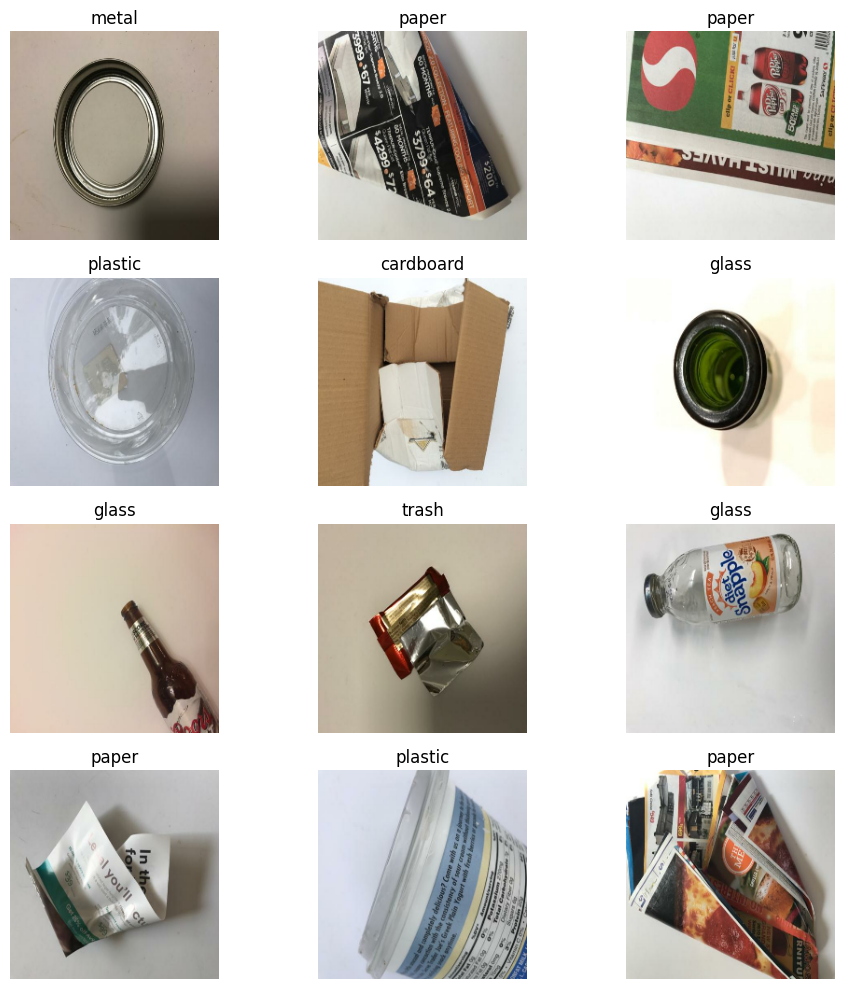

In [7]:
import matplotlib.pyplot as plt

# Display 12 sample images from the training set
plt.figure(figsize=(10, 10))

# Take a single batch from the dataset
for images, labels in train_ds.take(1):
    num_images = min(12, len(images))  # Ensure we don't exceed batch size
    for i in range(num_images):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
def count_distribution(dataset, class_names):
    import numpy as np
    from collections import Counter

    label_list = []

    # Accumulate all labels into a flat list
    for _, labels in dataset:
        label_list.extend(labels.numpy())

    total = len(label_list)
    counts = Counter(label_list)

    # Convert to dictionary with class names and percentage
    distribution = {
        class_names[i]: round((counts[i] / total) * 100, 2)
        for i in range(len(class_names))
    }

    return distribution

In [9]:
# Function to plot class distribution
def simple_bar_plot(distribution, title="Class Distribution"):
    import matplotlib.pyplot as plt

    classes = list(distribution.keys())
    values = list(distribution.values())

    plt.figure(figsize=(8, 5))
    plt.bar(classes, values, color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Class Names')
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [10]:
# Get class names before any transformations
# class_names = train_ds.class_names

# Compute distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)

# Compute average of train and val distribution as overall estimate
overall_dist = {
    cls: round((train_dist.get(cls, 0) + val_dist.get(cls, 0)) / 2, 2)
    for cls in class_names
}

# Display distributions
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution (Train+Val Avg):", overall_dist)

Train Distribution: {'cardboard': 15.3, 'glass': 16.34, 'metal': 19.7, 'paper': 27.24, 'plastic': 16.79, 'trash': 4.63}
Validation Distribution: {'cardboard': 14.63, 'glass': 13.43, 'metal': 18.51, 'paper': 25.97, 'plastic': 23.58, 'trash': 3.88}
Test Distribution: {'cardboard': 15.62, 'glass': 11.88, 'metal': 20.62, 'paper': 26.25, 'plastic': 22.5, 'trash': 3.12}
Overall Distribution (Train+Val Avg): {'cardboard': 14.96, 'glass': 14.88, 'metal': 19.11, 'paper': 26.6, 'plastic': 20.18, 'trash': 4.25}


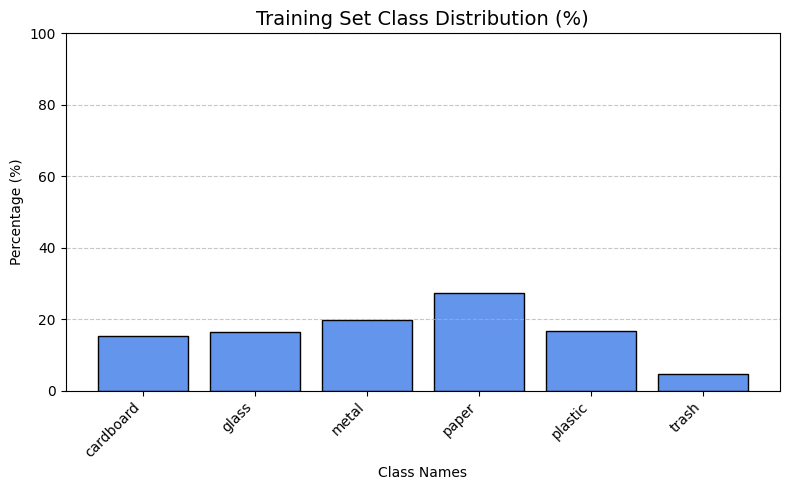

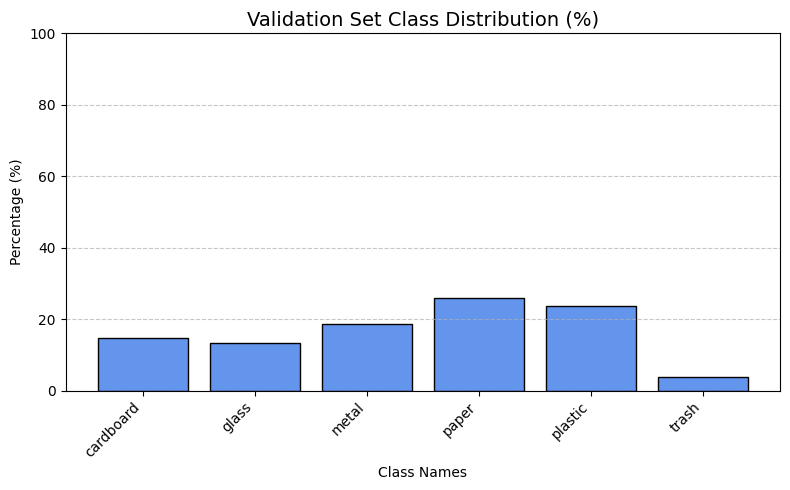

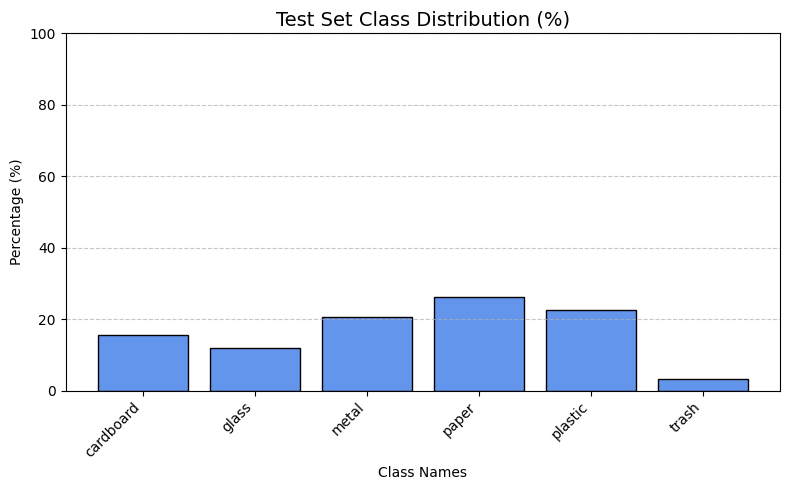

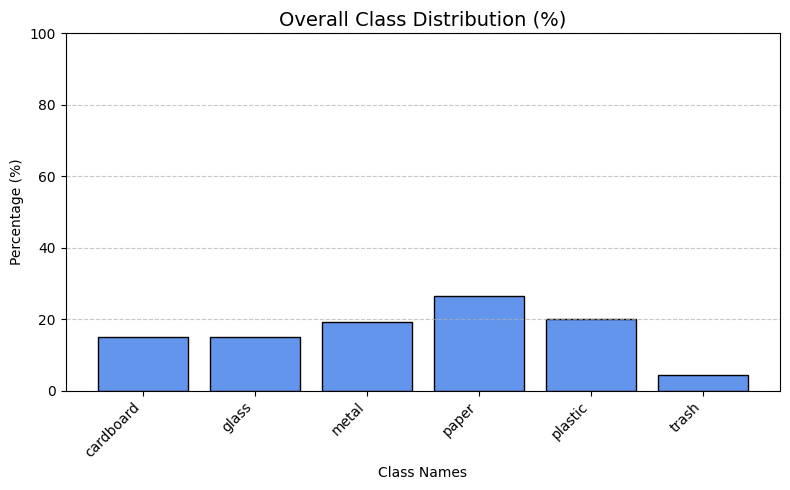

In [11]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [13]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 205, 1: 219, 2: 264, 3: 365, 4: 225, 5: 62}
Class Weights: {0: np.float64(1.089430894308943), 1: np.float64(1.0197869101978692), 2: np.float64(0.8459595959595959), 3: np.float64(0.6118721461187214), 4: np.float64(0.9925925925925926), 5: np.float64(3.6021505376344085)}


In [14]:
#  Define data augmentation pipeline
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [15]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    weights='imagenet'
)


In [16]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),  # ✅ Fix here
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Adjust based on number of classes
])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 7, 7, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [18]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 🚨 Stop training early if validation loss doesn't improve for 4 epochs
early = EarlyStopping(
    monitor='val_loss',          # Metric to monitor
    patience=4,                  # Wait 4 epochs before stopping
    restore_best_weights=True    # Restore model weights from best epoch
)

# 📉 Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Metric to watch
    patience=3,                  # Wait 3 epochs with no improvement
    factor=0.2,                  # Reduce learning rate by this factor
    verbose=1                    # Print when learning rate is reduced
)

# 💾 Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'Effiicientnetv2b2.keras',             # File to save the model weights
    monitor='val_accuracy',      # Save based on best validation accuracy
    save_best_only=True,         # Only save if current is better than previous best
    verbose=1                    # Print when model is saved
)

# 🧠 Train the model
history = model.fit(
    train_ds,                    # Training dataset
    validation_data=val_ds,      # Validation dataset
    epochs=12,                   # Total number of training epochs
    class_weight=class_weights,  # Handle class imbalance by giving more weight to minority classes
    batch_size=32,               # Number of samples per training batch
    callbacks=[                  # Use all the callbacks defined above
        early,
        reduce_lr,
        checkpoint
    ]
)


Epoch 1/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3227 - loss: 1.6372    
Epoch 1: val_accuracy improved from -inf to 0.66567, saving model to Effiicientnetv2b2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 717s 8s/step - accuracy: 0.3254 - loss: 1.6345 - val_accuracy: 0.6657 - val_loss: 1.1382 - learning_rate: 1.0000e-04
Epoch 2/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7043 - loss: 1.0064  
Epoch 2: val_accuracy improved from 0.66567 to 0.80299, saving model to Effiicientnetv2b2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.7049 - loss: 1.0046 - val_accuracy: 0.8030 - val_loss: 0.7418 - learning_rate: 1.0000e-04
Epoch 3/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8011 - loss: 0.6450   
Epoch 3: val_accuracy improved from 0.80299 to 0.86866, saving model to Effiicientnetv2b2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 399s 9s/step - accuracy: 0.8017 - loss: 0.6433 - val_accuracy: 0.8687 - val_loss: 0.5115 - learning_rate: 1.0000e-04
Epoch 4/12
42/42 ━━━━━━━━

In [20]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 112, 112, 16)      │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 112, 112, 16)      │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 112, 112, 16)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 112, 112, 16)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 112, 112, 16)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

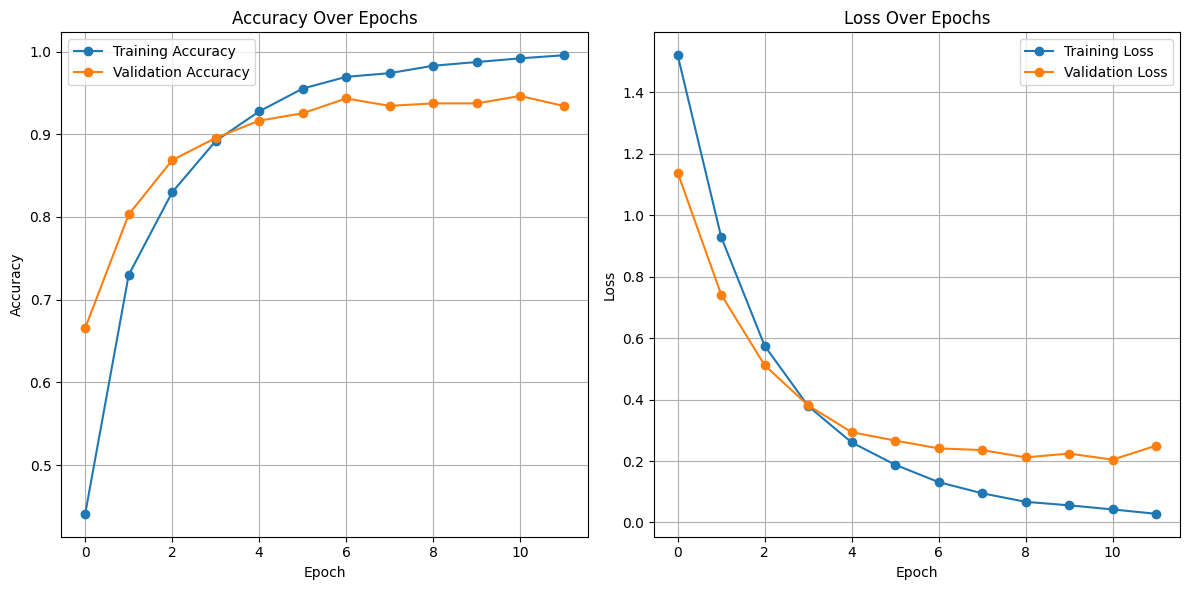

In [21]:
import matplotlib.pyplot as plt

# Plotting training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.9198 - loss: 0.2480
Test accuracy is0.9312, Test loss is 0.2262


In [23]:
#Get ground truth labels
y_true = np.concatenate([labels.numpy() for _, labels in test_ds_eval], axis=0)

# Predict class probabilities
y_pred_probs = model.predict(test_ds_eval)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(
    y_true, y_pred, target_names=class_names
))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step
Confusion Matrix:
 [[21  0  0  3  0  0]
 [ 0 19  0  0  0  0]
 [ 0  1 32  0  0  0]
 [ 0  0  0 36  0  0]
 [ 0  0  1  1 35  1]
 [ 0  0  1  3  0  6]]

Classification Report:
               precision    recall  f1-score   support

   cardboard       1.00      0.88      0.93        24
       glass       0.95      1.00      0.97        19
       metal       0.94      0.97      0.96        33
       paper       0.84      1.00      0.91        36
     plastic       1.00      0.92      0.96        38
       trash       0.86      0.60      0.71        10

    accuracy                           0.93       160
   macro avg       0.93      0.89      0.91       160
weighted avg       0.94      0.93      0.93       160



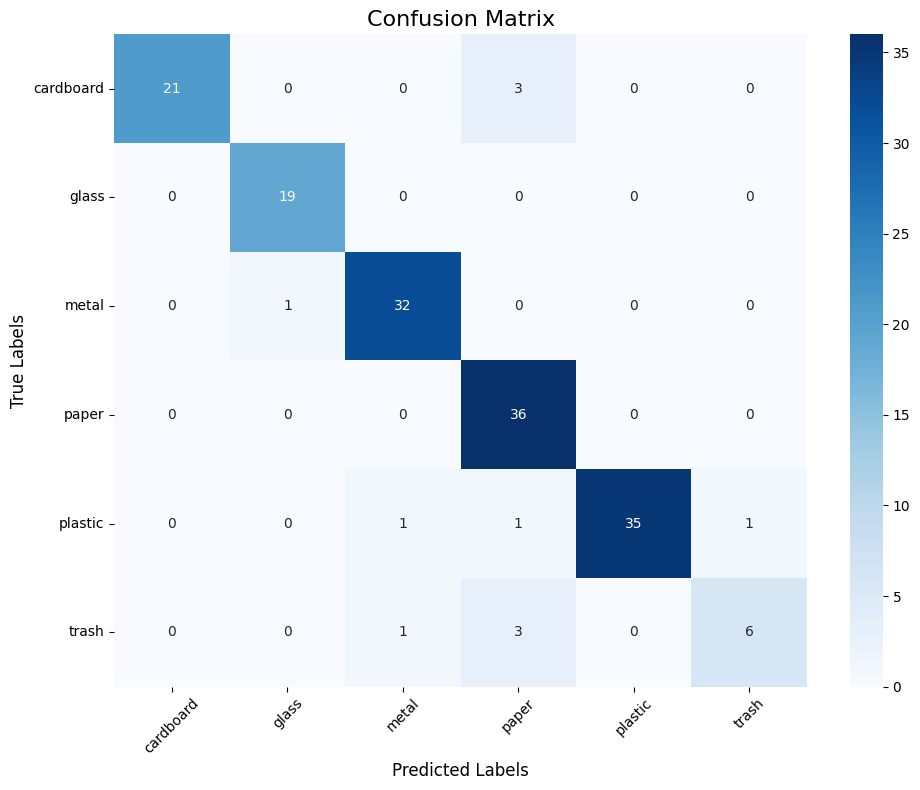

In [24]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,               # Show numbers in cells
    fmt='d',                  # Integer format
    cmap='Blues',             # Color map
    xticklabels=class_names,  # X-axis: predicted
    yticklabels=class_names   # Y-axis: true
)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


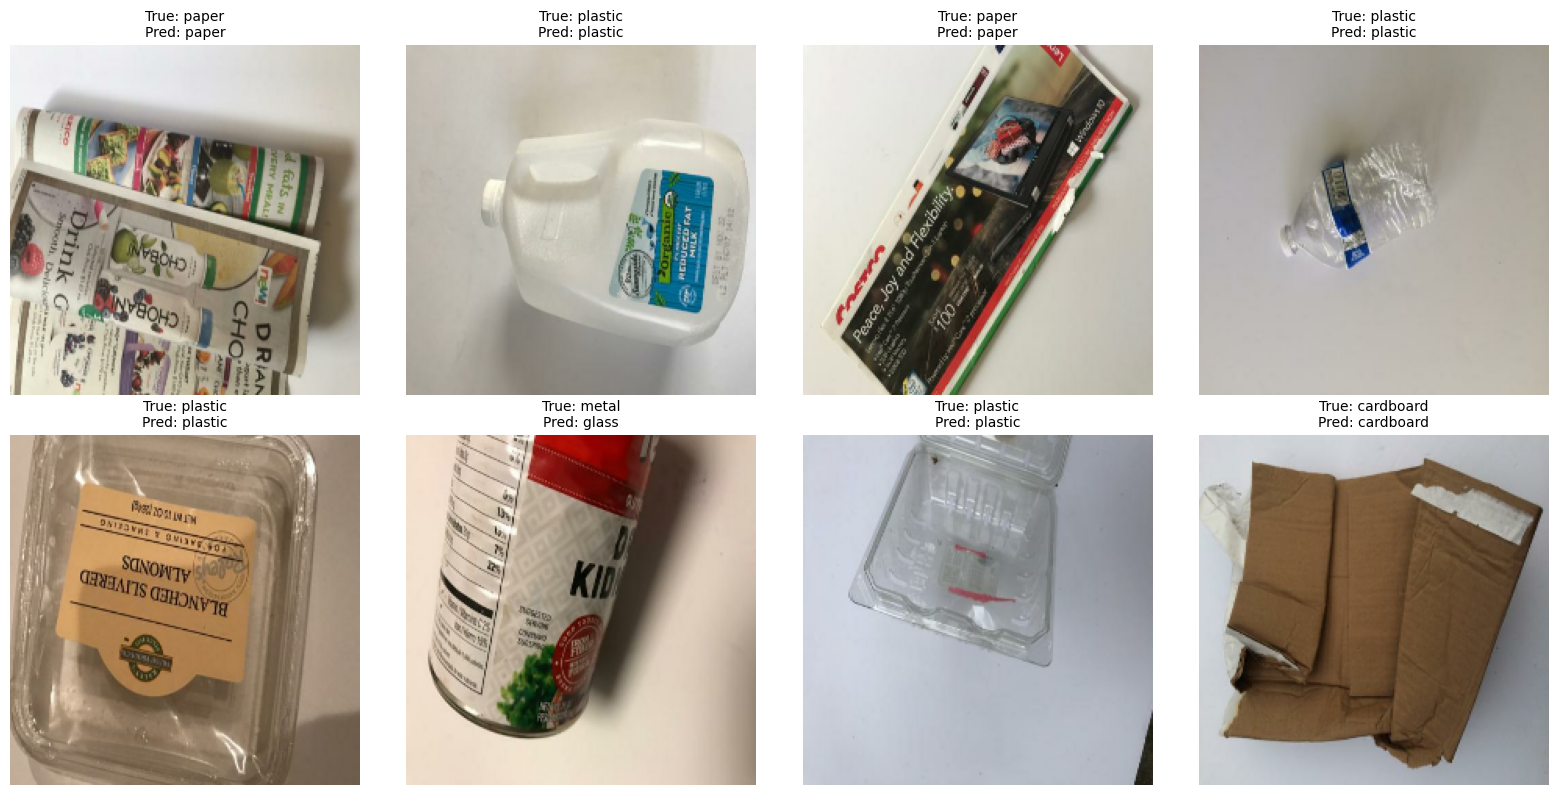

In [25]:
# Extract class names from the training dataset

# Take one batch from the test dataset
for images, labels in test_ds_eval.take(1):
    # Predict class probabilities for the batch
    predictions = model.predict(images)

    # Get class indices with highest probabilities
    pred_labels = tf.argmax(predictions, axis=1)

    # Setup plot grid
    plt.figure(figsize=(16, 8))
    for i in range(8):  # Show first 8 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        predicted_label = class_names[pred_labels[i].numpy()]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [26]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [5]:
pip install panel



  Using cached panel-1.7.2-py3-none-any.whl.metadata (15 kB)
  Using cached bokeh-3.7.3-py3-none-any.whl.metadata (12 kB)
  Using cached linkify_it_py-2.0.3-py3-none-any.whl.metadata (8.5 kB)
  Using cached mdit_py_plugins-0.4.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached param-2.2.1-py3-none-any.whl.metadata (6.6 kB)
  Using cached pyviz_comms-3.0.6-py3-none-any.whl.metadata (7.7 kB)
  Using cached xyzservices-2025.4.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached uc_micro_py-1.0.3-py3-none-any.whl.metadata (2.0 kB)
Using cached panel-1.7.2-py3-none-any.whl (29.6 MB)
Using cached bokeh-3.7.3-py3-none-any.whl (7.0 MB)
Using cached param-2.2.1-py3-none-any.whl (119 kB)
Using cached pyviz_comms-3.0.6-py3-none-any.whl (84 kB)
Using cached xyzservices-2025.4.0-py3-none-any.whl (90 kB)
Using cached linkify_it_py-2.0.3-py3-none-any.whl (19 kB)
Using cached mdit_py_plugins-0.4.2-py3-none-any.whl (55 kB)
Using cached uc_micro_py-1.0.3-py3-none-any.whl (6.2 kB)

   ---- -------------

In [12]:
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("Effiicientnetv2b2.keras")
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
suggestions = {
    "cardboard": "♻️ Flatten and recycle or reuse. Keep dry.",
    "glass": "🧴 Rinse and recycle in a separate bin. Avoid breakage.",
    "metal": "🥫 Clean and recycle. Separate sharp items safely.",
    "paper": "📄 Reuse if clean. Recycle dry paper only.",
    "plastic": "🚯 Check plastic type. Recycle where facilities exist.",
    "trash": "🚮 Not recyclable. Reduce use of non-recyclables."
}

# ⛏️ Fixed: Manually resize the image to 224x224
def predict_image(image):
    image = image.resize((224, 224))  # Ensures correct shape
    img_array = np.array(image, dtype=np.float32)
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    idx = np.argmax(prediction)
    class_name = class_names[idx]
    confidence = float(prediction[0][idx])
    suggestion = suggestions.get(class_name, "No suggestion available.")
    return f"🧠 **Prediction:** {class_name.upper()}\n✅ **Confidence:** {confidence * 100:.2f}%\n📌 **Suggestion:** {suggestion}"

# Gradio interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Garbage Image"),
    outputs="markdown",
    title="🗑️ Garbage Image Classifier",
    description="Upload an image of garbage to classify and get recycling suggestions."
)

demo.launch(share=False, inline=True)


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
